# 4. 이미지 어디까지 우려볼까?

**텐서플로우의 random augmentation 기법을 적용해 보고, 최신 augmentation 기법을 익힌다. 직접 모델을 학습시켜 비교 실험을 진행해 본다.**

## 4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기

---

### 목차
1. Augmentation을 적용한 데이터셋 만들기
2. 모델 만들기
3. 모델 훈련하기
4. 훈련 과정 시각화하기
5. Augmentation에 의한 모델 성능 비교

---

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1. Augmentation을 적용한 데이터셋 만들기
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

#### 데이터셋
- [stanford_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs)
    - 120개 견종의 이미지
    - 총 20,580장의 이미지 = 12,000장 학습셋 + 8,580장 평가용 데이터셋

- 데이터셋 불러오기

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

- 데이터셋 features 확인

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


- 데이터셋 개수 확인

In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(18610, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(4652, shape=(), dtype=int64)

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


- 데이터셋 클래스 개수 및 구성 확인

In [6]:
NUM_CLASSES = ds_info.features["label"].num_classes
NUM_CLASSES  # 120

120

In [7]:
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

- 각 이미지 클래스와 인덱스 확인
    - 학습용 데이터셋 확인

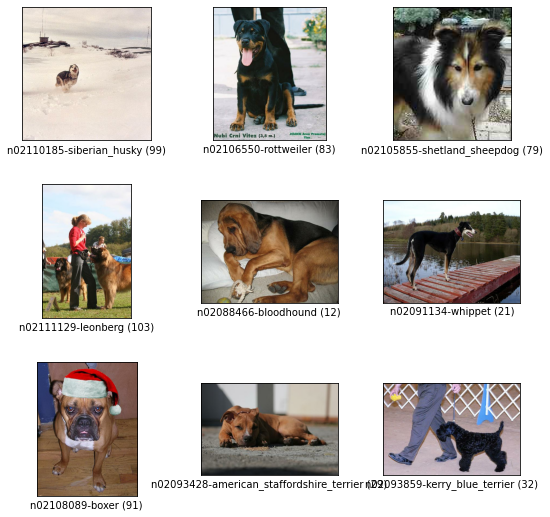

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

#### 이미지 전처리

- 학습 데이터와 검증 데이터에 normalizing 과 resizing 적용
    - 입력받은 이미지를 0~1 사이의 float32로 normalize
    - (224, 224) 사이즈로 resize

In [9]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

print('=3')

=3


- augmentation 적용 함수
    - 텐서플로우 Random Augmentation API 사용
        - random_brightness(): 명도 조절
        - random_contrast(): 대비 조절
        - random_crop(): 자르기
        - random_flip_left_right(): 좌우 대칭
        - random_flip_up_down(): 상하 대칭
        - random_hue(): 색상 조절
        - random_jpeg_quality(): jpeg 인코딩 품질 변경
        - random_saturation(): 채도 조절
    - 학습용 데이터셋에서 강아지 이미지에 큰 영향이 없게끔 brightness, flip_left_right 만 적용

In [10]:
def augment(image,label):
    # image = tf.image.flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    # image = tf.image.random_crop(image,[180,180,3])
    return image, label

print('=3')

=3


- cutmix 적용 함수

In [11]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [12]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [13]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [14]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


- mixup 적용 함수

In [15]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [16]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


- 원핫 인코딩 적용 함수

In [17]:
def onehot(image, label, num_classes=120):
    label_one_hot = tf.one_hot(label, num_classes)
    return image, label_one_hot

- 데이터 가공 함수
    - normalize, resize, augmentation, shuffle 적용
    - 테스트 데이터셋에는 augmentation, shuffle 를 적용하지 않아야 한다!

In [18]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,  # normalizing 과 resizing 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment  # augment 함수 적용
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,  # cutmix augment 함수 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,  # mixup augment 함수 적용
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,  # one - hot encoding
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


- 데이터 가공 적용 후 확인

In [19]:
# BATCH_SIZE = 16

strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [20]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)
print('=3')

=3


- 이미지 확인 함수

In [21]:
# 데이터셋에서 이미지 가져와서 시각화
def draw_ds_train(ds_train, batch_size=16, row=6, col=4):
    row = min(row, batch_size//col)  # row 재설정
    
    # 데이터셋에서 배치 사이즈(=16개)만큼 1번만 이미지 가져오기
    for i, (image, label) in enumerate(ds_train.take(1)):
        
        plt.figure(figsize=(8,int(8*row/col)))  # 8x8 크기
        for j in range(row*col):
            plt.subplot(row,col,j+1)
            plt.axis('off')
            plt.imshow(image[j,])  # 가져온 이미지(16개) 하나씩 출력
                    
        plt.tight_layout()
        plt.show()

- No Aug 이미지 확인

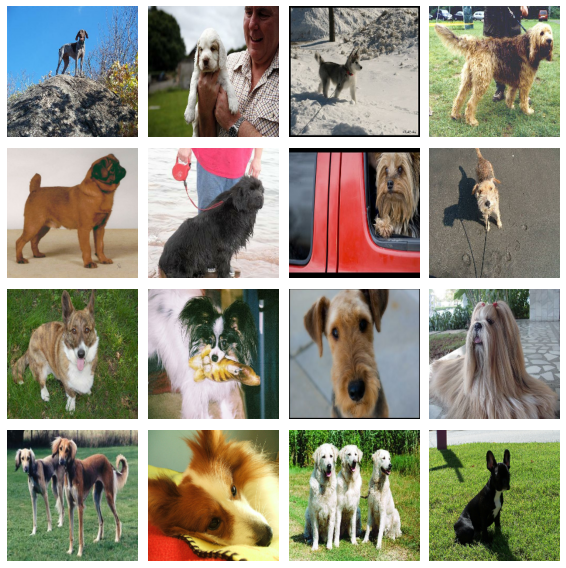

In [22]:
draw_ds_train(ds_train_no_aug, BATCH_SIZE)

- Aug 적용 이미지 확인

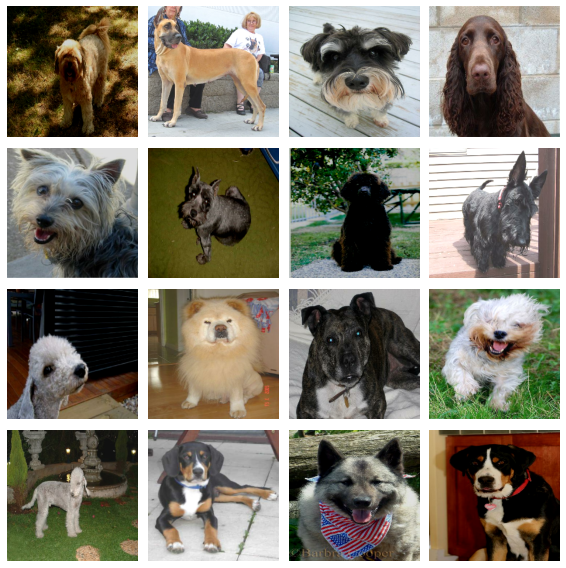

In [23]:
draw_ds_train(ds_train_aug, BATCH_SIZE)

- CutMix 적용 이미지 확인

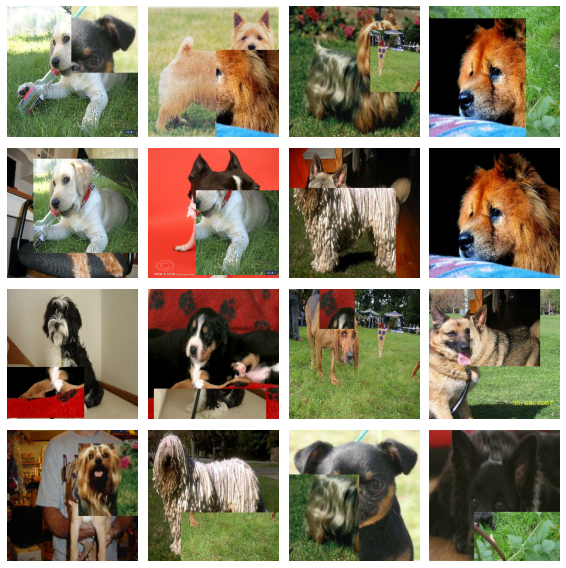

In [24]:
draw_ds_train(ds_train_aug_cutmix, BATCH_SIZE)

- Mixup 적용 이미지 확인

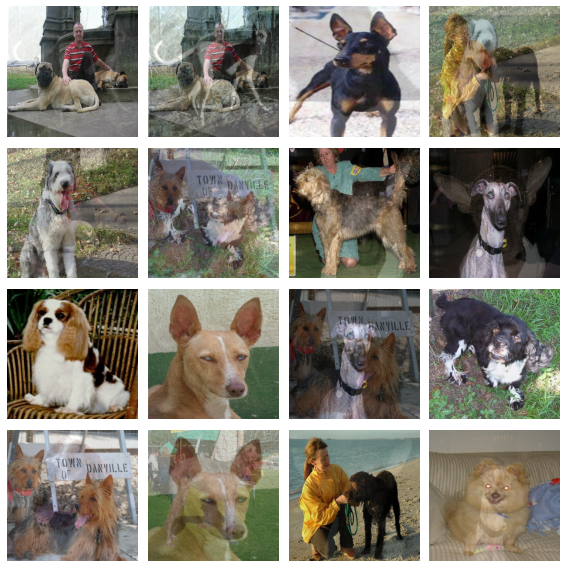

In [25]:
draw_ds_train(ds_train_aug_mixup, BATCH_SIZE)

### 2. 모델 만들기
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

#### ResNet50

- ResNet50 생성 함수

In [26]:
def create_ResNet50(include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='avg',
                    num_classes=120,
                    activation='softmax'):
                    
    resnet50 = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape,
            pooling=pooling,
        ),
        keras.layers.Dense(num_classes, activation=activation)
    ])
    return resnet50

- ResNet50 생성

In [27]:
resnet50_no_aug = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_no_aug 으로 학습시킬 ResNet
resnet50_aug = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug 으로 학습시킬 ResNet
resnet50_aug_cutmix = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug_cutmix 으로 학습시킬 ResNet
resnet50_aug_mixup = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug_mixup 으로 학습시킬 ResNet

### 3. 모델 훈련하기
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

#### 상수 설정

- EPOCH 설정

In [28]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 30

LEARNING_RATE = 0.01

- Custom [LR scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler)

Learning rate schedule: 0.001 to 0.05 to 0.000336


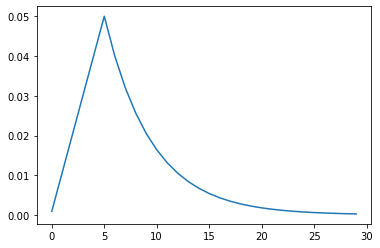

In [29]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.001  # 0.00001
LR_MAX = 0.05 * strategy.num_replicas_in_sync  # 0.00005
LR_MIN = 0.0001  # 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCH<25 else EPOCH)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

#### ResNet50 훈련

- ResNet50 훈련 함수

In [30]:
def compile_and_fit(resnet50,
                    ds_train,
                    ds_test,
                    ds_info,
                    learning_rate=0.01,
                    batch_size=16,
                    epochs=3):
                    
    resnet50.compile(
        loss='categorical_crossentropy',
        optimizer='sgd',
        # optimizer=tf.keras.optimizers.SGD(
        #     learning_rate=learning_rate,
        #     momentum=0.9,
        #     decay=0.0001,
        # ),
        metrics=['accuracy'],
    )

    history_resnet50 = resnet50.fit(
        ds_train, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epochs,
        callbacks=[lr_callback],
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history_resnet50

- No Augmentation

In [31]:
history_resnet50_no_aug = compile_and_fit(
    resnet50_no_aug,
    ds_train_no_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
750/750 [==============================] - 192s 244ms/step - loss: 4.4361 - accuracy: 0.0786 - val_loss: 4.5976 - val_accuracy: 0.0566 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/30
750/750 [==============================] - 182s 243ms/step - loss: 1.7903 - accuracy: 0.5225 - val_loss: 1.4641 - val_accuracy: 0.5833 - lr: 0.0108

Epoch 00003: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/30
750/750 [==============================] - 183s 244ms/step - loss: 1.0472 - accuracy: 0.6917 - val_loss: 1.5837 - val_accuracy: 0.5704 - lr: 0.0206

Epoch 00004: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/30
750/750 [==============================] - 183s 244ms/step - loss: 0.9015 - accuracy: 0.7270 - val_loss: 2.2150 - val_accuracy: 0.4630 - lr: 0.0304

Epoch 00005: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/30
750/750 [

- 기본 Augmentation

In [32]:
history_resnet50_aug = compile_and_fit(
    resnet50_aug,
    ds_train_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
750/750 [==============================] - 189s 245ms/step - loss: 4.4543 - accuracy: 0.0737 - val_loss: 4.4897 - val_accuracy: 0.0626 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/30
750/750 [==============================] - 183s 244ms/step - loss: 1.8535 - accuracy: 0.5067 - val_loss: 1.7061 - val_accuracy: 0.5335 - lr: 0.0108

Epoch 00003: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/30
750/750 [==============================] - 182s 243ms/step - loss: 1.2705 - accuracy: 0.6309 - val_loss: 1.8204 - val_accuracy: 0.5226 - lr: 0.0206

Epoch 00004: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/30
750/750 [==============================] - 183s 244ms/step - loss: 1.1924 - accuracy: 0.6522 - val_loss: 3.0157 - val_accuracy: 0.3235 - lr: 0.0304

Epoch 00005: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/30
750/750 [

- 기본 + CutMix 적용

In [33]:
history_resnet50_aug_cutmix = compile_and_fit(
    resnet50_aug_cutmix,
    ds_train_aug_cutmix,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
750/750 [==============================] - 195s 253ms/step - loss: 4.8659 - accuracy: 0.0246 - val_loss: 4.9811 - val_accuracy: 0.0321 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/30
750/750 [==============================] - 191s 254ms/step - loss: 3.6002 - accuracy: 0.2616 - val_loss: 1.7170 - val_accuracy: 0.5336 - lr: 0.0108

Epoch 00003: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/30
750/750 [==============================] - 192s 256ms/step - loss: 3.0473 - accuracy: 0.3957 - val_loss: 1.8984 - val_accuracy: 0.4927 - lr: 0.0206

Epoch 00004: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/30
750/750 [==============================] - 192s 256ms/step - loss: 2.8840 - accuracy: 0.4412 - val_loss: 2.3294 - val_accuracy: 0.4165 - lr: 0.0304

Epoch 00005: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/30
750/750 [

- 기본 + Mixup 적용

In [34]:
history_resnet50_aug_mixup = compile_and_fit(
    resnet50_aug_mixup,
    ds_train_aug_mixup,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
750/750 [==============================] - 197s 256ms/step - loss: 4.8458 - accuracy: 0.0237 - val_loss: 5.1664 - val_accuracy: 0.0177 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/30
750/750 [==============================] - 191s 255ms/step - loss: 3.4882 - accuracy: 0.2928 - val_loss: 1.8042 - val_accuracy: 0.5026 - lr: 0.0108

Epoch 00003: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/30
750/750 [==============================] - 192s 256ms/step - loss: 3.0198 - accuracy: 0.4206 - val_loss: 2.0438 - val_accuracy: 0.4613 - lr: 0.0206

Epoch 00004: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/30
750/750 [==============================] - 190s 254ms/step - loss: 2.8662 - accuracy: 0.4709 - val_loss: 2.4604 - val_accuracy: 0.3759 - lr: 0.0304

Epoch 00005: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/30
750/750 [

### 4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

- No Aug, With Aug, With CutMix, With Mixup 결과 시각화
    - Training Loss
    - Training Accuracy
    - Validation Loss
    - Validation Accuracy

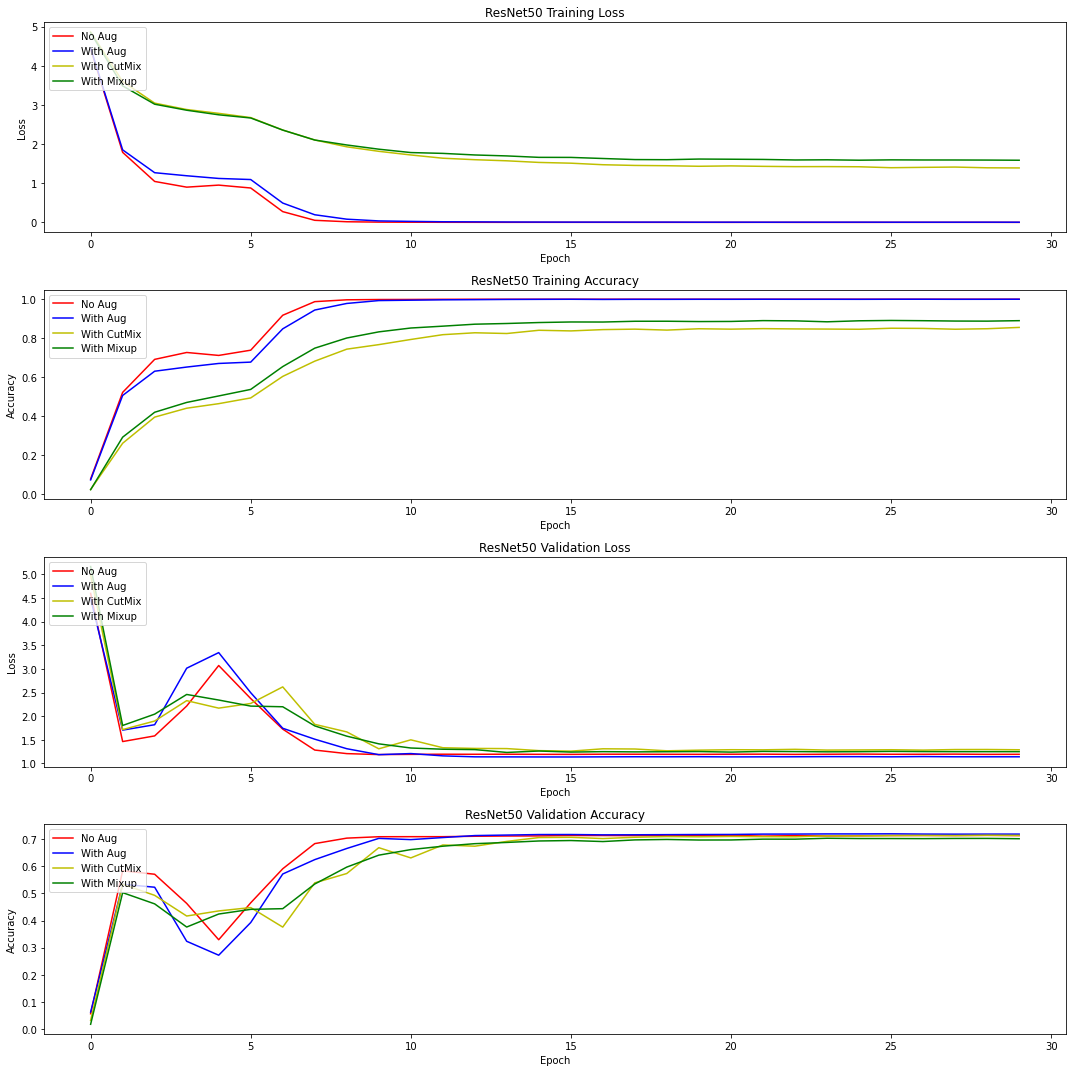

In [35]:
plt.subplots(figsize=(15,15))

# No Aug, With Aug, With CutMix, With Mixup 의 Training Loss 시각화
plt.subplot(411)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'g')
plt.title('ResNet50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Training Accuracy 시각화
plt.subplot(412)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'g')
plt.title('ResNet50 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Loss 시각화
plt.subplot(413)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'g')
plt.title('ResNet50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Accuracy 시각화
plt.subplot(414)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

plt.tight_layout()
plt.savefig('result/Results_With_all_Aug.png')  # 저장
plt.show()

- No Aug, With Aug, With CutMix, With Mixup 결과 중 Validation Accuracy 시각화

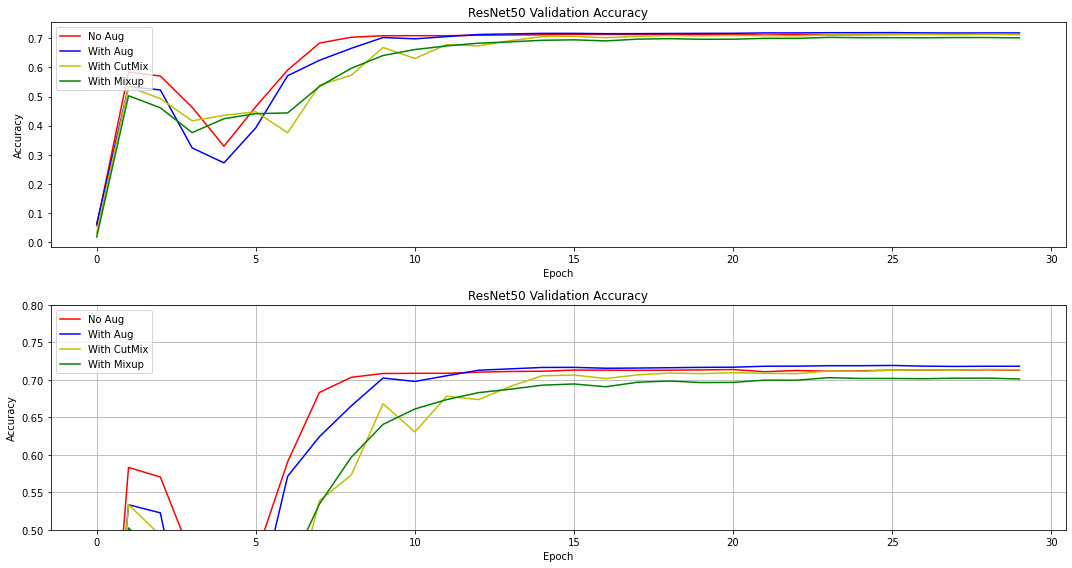

In [36]:
plt.subplots(figsize=(15,8))

# No Aug, With Aug, With CutMix, With Mixup Validation Accuracy 시각화
plt.subplot(211)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup Validation Accuracy 시각화 2
plt.subplot(212)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 

plt.tight_layout()
plt.savefig('result/Validation_Accuracy_With_Aug.png')  # 저장
plt.show()

### 5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

- 학습 결과 데이터 프레임으로 저장

In [39]:
def get_df_resnet50_result(col='val_accuracy'):
    # ResNet50 (No Aug, With Aug, With CutMix, With Mixup) 학습 결과 저장
    resnet50 = {
        'No Aug': history_resnet50_no_aug.history[col],
        'With Aug': history_resnet50_aug.history[col],
        'With CutMix': history_resnet50_aug_cutmix.history[col],
        'With Mixup': history_resnet50_aug_mixup.history[col]
    }

    # 데이터 프레임으로 생성
    df_resnet50 = pd.DataFrame(resnet50, index=[f'EPOCHS_{i}' for i in range(EPOCH)])
    return df_resnet50

In [46]:
df_resnet50_loss = get_df_resnet50_result('loss')
df_resnet50_loss

,No Aug,With Aug,With CutMix,With Mixup
EPOCHS_0,4.436059,4.454301,4.865944,4.845807
EPOCHS_1,1.790254,1.853480,3.600166,3.488223
EPOCHS_2,1.047184,1.270470,3.047255,3.019823
EPOCHS_3,0.901534,1.192421,2.883994,2.866154
EPOCHS_4,0.953528,1.123793,2.786424,2.749268
EPOCHS_5,0.879941,1.095834,2.678075,2.667964
EPOCHS_6,0.276314,0.495199,2.360409,2.358726
EPOCHS_7,0.054583,0.196211,2.105873,2.104962
EPOCHS_8,0.017927,0.083329,1.931738,1.978649
EPOCHS_9,0.008388,0.039112,1.816425,1.870984


In [47]:
df_resnet50_acc = get_df_resnet50_result('accuracy')
df_resnet50_acc

,No Aug,With Aug,With CutMix,With Mixup
EPOCHS_0,0.078583,0.073750,0.024583,0.023667
EPOCHS_1,0.522500,0.506667,0.261583,0.292750
EPOCHS_2,0.691667,0.630917,0.395667,0.420583
EPOCHS_3,0.727000,0.652250,0.441250,0.470917
EPOCHS_4,0.711917,0.670750,0.464583,0.504167
EPOCHS_5,0.738750,0.677583,0.494000,0.537667
EPOCHS_6,0.917833,0.848167,0.604333,0.654667
EPOCHS_7,0.987583,0.944583,0.682500,0.749083
EPOCHS_8,0.997000,0.978333,0.744000,0.801167
EPOCHS_9,0.998500,0.993083,0.767250,0.832667


In [48]:
df_resnet50_val_loss = get_df_resnet50_result('val_loss')
df_resnet50_val_loss

,No Aug,With Aug,With CutMix,With Mixup
EPOCHS_0,4.597629,4.489695,4.981063,5.166419
EPOCHS_1,1.464130,1.706077,1.717047,1.804200
EPOCHS_2,1.583727,1.820377,1.898421,2.043811
EPOCHS_3,2.214992,3.015650,2.329423,2.460371
EPOCHS_4,3.072668,3.345539,2.171064,2.342362
EPOCHS_5,2.373652,2.497339,2.269722,2.214083
EPOCHS_6,1.726879,1.745157,2.620493,2.200105
EPOCHS_7,1.284189,1.514075,1.828088,1.795322
EPOCHS_8,1.209019,1.312744,1.668280,1.578179
EPOCHS_9,1.188595,1.186914,1.310956,1.415614


In [49]:
df_resnet50_val_acc = get_df_resnet50_result('val_accuracy')
df_resnet50_val_acc

,No Aug,With Aug,With CutMix,With Mixup
EPOCHS_0,0.056553,0.062617,0.032066,0.017724
EPOCHS_1,0.583256,0.533466,0.533582,0.502565
EPOCHS_2,0.570429,0.522621,0.492654,0.461287
EPOCHS_3,0.463036,0.323461,0.416511,0.375933
EPOCHS_4,0.329174,0.272155,0.435285,0.423857
EPOCHS_5,0.465252,0.392491,0.447645,0.441115
EPOCHS_6,0.590602,0.571362,0.375700,0.443563
EPOCHS_7,0.683302,0.624300,0.538713,0.534398
EPOCHS_8,0.703475,0.665345,0.573111,0.596782
EPOCHS_9,0.708605,0.702542,0.668260,0.640742


In [52]:
# ResNet50 (No Aug, With Aug, With CutMix, With Mixup) 학습 결과 평균값을 딕셔너리로 저장
resnet50_result = {
    'loss': round(df_resnet50_loss.mean(),2),
    'accuracy': round(df_resnet50_acc.mean(),2),
    'val_losss': round(df_resnet50_val_loss.mean(),2),
    'val_accuracy': round(df_resnet50_val_acc.mean(),2),
}

# 데이터 프레임 생성
df_resnet50_result = pd.DataFrame(resnet50_result)
df_resnet50_result

,loss,accuracy,val_losss,val_accuracy
No Aug,0.35,0.91,1.49,0.65
With Aug,0.40,0.90,1.52,0.63
With CutMix,1.92,0.72,1.63,0.62
With Mixup,2.02,0.76,1.61,0.61


In [54]:
df_resnet50_result['val_accuracy']

No Aug         0.65
With Aug       0.63
With CutMix    0.62
With Mixup     0.61
Name: val_accuracy, dtype: float64

---

#### 결과 정리

- 결과 시각화

||시각화|
|---|:---:|
|All Results|![](result/Results_With_all_Aug.png)|
|Only Validation Accuracy|![](result/Validation_Accuracy_With_Aug.png)|

- 결과 표

In [55]:
df_resnet50_result

,loss,accuracy,val_losss,val_accuracy
No Aug,0.35,0.91,1.49,0.65
With Aug,0.40,0.90,1.52,0.63
With CutMix,1.92,0.72,1.63,0.62
With Mixup,2.02,0.76,1.61,0.61


In [56]:
df_resnet50_result['val_accuracy']

No Aug         0.65
With Aug       0.63
With CutMix    0.62
With Mixup     0.61
Name: val_accuracy, dtype: float64

- 결론
    - Augmentation 을 적용하지 않은 데이터셋의 validation accuracy 평균 값이 가장 높았다.
    - CutMix 나 Mixup 은 validation accuracy 값을 높이는데 있어 효과가 없었다.
    - Epochs=30 으로 진행해봤으나 Epochs=10 의 결과와 비슷했다.
    - batch_size=32 와 batch_size=16 의 결과도 비슷했다.
    - LR Scheduler 를 사용해봤지만 성능 향상의 효과를 보지 못했다.
    - validation accuracy 평균값 0.6x 을 벗어나지를 못했다.

=> **Data Augmentation 이 무조건 성능 향상을 가져오진 않는다!**

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
Augmentation 이 항상 성능 향상을 이루어내지는 못한다. 몇 번을 다시 돌려봐도 같은 결과만을 맞이했다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- Augmentation
    - CNN 은 파라미터 수가 많아서 데이터가 적으면 오버피팅이 될 수 있다. => 일반화가 되지 않는 문제 발생 => 해결: Data Augmentation
    - 학습 데이터셋의 양을 늘리는 효과
    - Mixup, Cutout, CutMix<br>![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb48kop%2Fbtq4W1ukB1b%2F1eAfefIuKNDKtbGYc2ughk%2Fimg.png)
- [Mixup](https://arxiv.org/abs/1710.09412) [[논문 리뷰]](https://hoya012.github.io/blog/Improved-Regularization-of-Convolutional-Neural-Networks-with-Cutout-Review/)
    - 특정 비율로 픽셀별 값을 섞는 방식
    - 두 개의 이미지가 선형 보간됨 => 이미지 정보가 왜곡되는 문제 발생
- [Cutout](https://arxiv.org/abs/1708.04552)
    - 모델의 훈련과정 동안 입력 이미지에서 무작위로 정사각 영역을 가리는 단순한 규제방법
    - cutout 방식을 제안하는 가장 큰 이유는 컴퓨터 비전 작업에서 자주 맞닥뜨리게 되는 object occlusion 문제 해결을 위해서다.
- [Cutmix](https://arxiv.org/pdf/1905.04899.pdf)
    - cut-and-paste 방법
    - 지역적으로 이미지를 잘라내고 잘라낸 부분에 다른 이미지의 패치를 덧붙임
    - image classification, weakly-supervised localization 태스크 등에서 일관된 높은 성능을 보임
- LR Scheduler
    - [설명](https://ai4nlp.tistory.com/8)
        - 실제 학습을 할 때에 어떤 Lr Scheduler를 고르느냐, Lr Scheduler의 Hyperparameter로 어떤 값을 고르느냐에 따라 학습 결과에는 큰 차이가 존재
        - 미리 학습 일정을 정해두고, 그 일정에 따라 학습률을 조정하는 방법
        - 일반적으로는 warmup이라는 파라미터를 정하고 현재 step이 warmup보다 낮을 경우는 learning rate를 linear하게 증가 시키고, warmup 후에는 각 Lr Scheduler에서 정한 방법대로 learning rate를 update
    - 구현
        - Pytorch [[참고1]](https://gaussian37.github.io/dl-pytorch-lr_scheduler/)  [[참고2]](https://dacon.io/codeshare/2373)
            - LAMBDA LR: Epoch에 따른 가중치로 lr 를 점점 감소 시키는 Scheduler
            - MultiplicativeLR: 이전 Epoch에 따른 가중치로 lr 를 감소시키는 Scheduler
            - StepLR: 특정 Step에 따라 lr 를 감소시키는 Scheduler
            - MultiStepLR: 특정 Step에 따른 감소가 아닌 사용자가 지정한 milestones 에 따라 lr 를 감소시키는 Scheduler
            - ExponentialLR
            - CosineAnnealingLR: Cosine 파형을 사용하는 Scheduler
            - CyclicLR
                - triangular
                - triangular2
                - exp_range
            - OneCycleLR
                - cos
                - linear
            - CosineAnnealingWarmRestarts
        - Tensorflow
            - tf.keras.callbacks.LearningRateScheduler
            - [[Keras 학습에 사용되는 Callback 4가지]](https://rinha7.github.io/keras-callbacks/)
- 참고: [[GPU/TPU의 CutMix 및 MixUp]](https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook#MixUp-Augmentation)


### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
>|2|다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함|
>|3|여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

ResNet50 모델에 No Aug, With Aug, With CutMix, With Mixup 적용 데이터셋을 일일이 학습시켰다. Augmentation 기법을 적용했을 때보다 성능이 향상되었음을 볼 수 없었다. 학습 결과를 선 그래프로 시각화했고 validation accuracy 평균 값을 통해 어떤 데이터셋의 성능이 높게 평가되는지 확인했다. 결과적으로 No Aug 데이터셋이 가장 validation accuracy 가 높았다.


### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
인공지능은 정말 정답이 없구나